#### Vamos a hacer un _mixed_ recommendation system, en el que simplemente se hacen $k$ recomendaciones de cada uno, y se combinan las dos listas para obtener $k$ recomendaciones.

- Si un item está en las dos listas, se escoge sí o sí (sin importar su posición en la lista)
- Los huecos restantes se rellenan con un item de cada lista alternativamente

Es decir, si R1 recomienda {A,B,C,D,E} y R2 recomienda {A,D,F,G,H,I}, el recomendador mixto recomendaría {A,D,B,F,C}. A y D se recomiendan porque están en ambas, y luego se recomendaría el restante de cada uno.

In [1]:
from pathlib import Path
import itertools as it

import pandas as pd
import numpy as np

from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt

from src import paths
from src.datasets import daocensus_text, to_microsoft
from src.models.nlp import NLPModel, NLPSimilarity

%load_ext autoreload
%autoreload 2

/tmp/ipykernel_3945966/641890083.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-02-04 16:31:30.326316: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 16:31:30.326337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 16:31:30.326350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
ORG_NAME = 'Decentraland'
SPLITS_FREQ = 'W-THU'
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00
SEED: int = 42
K_RECOMMENDATIONS = [5, 10]

# To evaluate the hybrid recommender system
MERGE_FUNC = 'naive' # one of 'avg', 'naive', 'prioritize'

# These two files are generated by 09_analyze_results.ipynb
BEST_HPARAMS_FILE = paths.hybrid_best_hparams(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
REALISTIC_HPARAMS_FILE = paths.hybrid_realisitc_hparams(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

# Reading the dataset

In [3]:
# dfptext = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfv['voter'] = dfv['voter'].astype('str')
# dfp = dfp.merge(dfptext, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, 'snapshot')
dfv['voter'] = dfv['voter'].astype('str')
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116560 entries, 0 to 116559
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       116560 non-null  object        
 1   name           116560 non-null  object        
 2   id             116560 non-null  object        
 3   proposal       116560 non-null  category      
 4   deployment     116560 non-null  object        
 5   platform_vote  116560 non-null  object        
 6   voter          116560 non-null  object        
 7   date           116560 non-null  datetime64[ns]
 8   choice         116560 non-null  object        
 9   weight         116560 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(7)
memory usage: 8.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1943 entries, 0f4784fc-022a-5047-8bfe-e16ac3bd0984 to 629184e6-f8b2-5270-b358-252369d7599d
Data columns (total 12 column

In [4]:
from src.model_selection import timeFreqSplitCurrent

df = to_microsoft(dfv)
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'))
f = folds[0][0]
f

,userID,itemID,timestamp,rating
7695,0xe161cc33f5b430be52aa69520d32cd3f39fa2be6,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-26 23:49:47,1
7696,0x338ad1918362025f34b3701dac1e9648e8e8268f,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-26 23:49:34,1
7697,0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-26 23:28:08,1
7698,0xffac7fd045303112fdb28e9dace8e1334ad324c0,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-26 23:21:51,1
7699,0xd210dc1dd26751503cbf1b8c9154224707820da8,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,2021-05-26 21:58:01,1
...,...,...,...,...
108178,0x8cff6832174091dae86f0244e3fd92d4ced2fe07,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:41:41,1
108179,0xec6e6c0841a2ba474e92bf42baf76bfe80e8657c,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:40:41,1
108180,0xe2b6024873d218b2e83b462d3658d8d7c3f55a18,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:40:40,1
108181,0xd210dc1dd26751503cbf1b8c9154224707820da8,954eac50-670b-5b29-b2a9-f97bfbfab26b,2021-05-24 17:37:43,1


# Creating the model

In [5]:
from src.models.hybrid import HybridRecommendation

lightgcn_config = dict(
    n_layers=3,
    batch_size=512,
    embed_size=64,
    epochs=2,
    learning_rate=0.001,
    decay=0.00001,
    metrics=[],
    eval_epoch=2,
    top_k=5,
    save_model=False,
    MODEL_DIR='/tmp/hybrid-model', # Will be ignored
    cf_seed=SEED,
)

nlp_config = dict(
    # filter_window='14d',
)

hr = HybridRecommendation(folds[0][0], folds[0][1], dfp, lightgcn_config=lightgcn_config, nlp_config=nlp_config)
hr

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [6]:
hr.fit()

Epoch 1 (train)0.1s: train loss = 0.67300 = (mf)0.67299 + (embed)0.00002
Epoch 2 (train)0.0s + (eval)0.7s: train loss = 0.67202 = (mf)0.67200 + (embed)0.00002, 
Some embeddings need to be calculated


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# hr.recommend_k_items(['0x29d5cea7d511810f3ff754886b898fce16a6d8fd', '0x30b1f4bd5476906f38385b891f2c09973196b742'], top_k=3)

In [8]:
train_users = set(folds[0][0]['userID'])
test_users = set(folds[0][1]['userID'])

in_test_not_in_train = test_users.difference(train_users)
assert in_test_not_in_train == set()

In [9]:
hr.recommend_k_items(folds[0][1]['userID'].unique(), top_k=3)

,userID,itemID,prediction,rec
0,0x1177ba1e2fa6dbf1c9753c4e3405410173af1e83,45a12f85-4bab-51a7-982a-06705ad469c9,0,nlp
1,0x1177ba1e2fa6dbf1c9753c4e3405410173af1e83,954eac50-670b-5b29-b2a9-f97bfbfab26b,0,gnn
2,0x1177ba1e2fa6dbf1c9753c4e3405410173af1e83,0a85880b-e091-58b4-88d3-cf30112dee14,1,nlp
3,0x1177ba1e2fa6dbf1c9753c4e3405410173af1e83,02d46cbb-7178-57b3-993e-94aa0644b826,1,gnn
4,0x1177ba1e2fa6dbf1c9753c4e3405410173af1e83,e00cd697-dd7b-5836-91b4-73cb5c8f9cc9,2,nlp
...,...,...,...,...
200,0xf7e158bd2b6e79ef2f2ab72ac6cb2fea239c2a9b,0a179f47-918b-5116-a453-bba13ecc477f,0,nlp
201,0xf7e158bd2b6e79ef2f2ab72ac6cb2fea239c2a9b,954eac50-670b-5b29-b2a9-f97bfbfab26b,0,gnn
202,0xf7e158bd2b6e79ef2f2ab72ac6cb2fea239c2a9b,566eaf46-1c59-5907-8800-8eadb863f851,1,nlp
203,0xf7e158bd2b6e79ef2f2ab72ac6cb2fea239c2a9b,bc3ec30e-b7f7-5de5-aa8e-8acf9d430887,1,gnn


# Evaluating the model

In [10]:
hparams_df = pd.read_csv(BEST_HPARAMS_FILE, index_col=0)
hparams_df

,config/fold,config/iteration,loss,mf_loss,emb_loss,precision@5,ndcg@5,recall@5,map@5,precision@10,...,map@10,time_total_train,time_total_test,done,trial_id,config/batch_size,config/embedding_dim,config/conv_layers,config/learning_rate,config/l2
0,0,35,10.907020,9.772025,1.134994,0.267692,0.546919,0.630948,0.470984,0.192308,...,0.521334,148.688826,3.210953,False,4995b757,512,187,4,0.6997,2.076458e-06
1,1,50,15.108801,1.951643,13.157159,0.317007,0.428404,0.356074,0.288366,0.285034,...,0.378426,244.734964,1.685182,False,4f678a67,256,58,2,0.6601,5.166907e-03
2,2,30,0.184071,0.175205,0.008866,0.285185,0.529232,0.570937,0.424200,0.204630,...,0.486664,61.743998,1.225487,False,db0d03b4,512,5,3,0.2200,5.242816e-05
3,3,30,3.376006,0.446829,2.929177,0.352809,0.540350,0.562584,0.453278,0.270787,...,0.550324,78.903504,2.335335,False,4e3ecf81,512,35,2,0.5635,8.225524e-03
4,4,30,0.297812,0.295491,0.002322,0.372340,0.576458,0.619928,0.467970,0.277660,...,0.559843,123.538977,1.391723,False,881ea7a0,128,1,3,0.0347,5.910891e-05
5,5,40,0.362987,0.362825,0.000163,0.352727,0.549601,0.620590,0.442805,0.251818,...,0.516477,191.516362,2.394379,False,17e1a105,256,2,3,0.3888,8.435714e-07
6,6,25,0.715730,0.713467,0.002263,0.286614,0.610261,0.615120,0.518263,0.200000,...,0.571514,120.120703,3.163181,False,66798b7e,512,1,2,0.9794,4.849946e-05
7,7,15,0.126424,0.036114,0.090310,0.317391,0.633268,0.750233,0.548280,0.221739,...,0.622719,107.628664,2.617779,False,5e639d92,256,54,2,0.0399,4.331755e-03
8,8,40,0.803874,0.661557,0.142317,0.260606,0.418252,0.457338,0.295932,0.218182,...,0.364169,122.407406,3.042897,False,c5cb4e78,512,18,3,0.2600,5.365198e-05
9,9,5,0.051391,0.041375,0.010016,0.225532,0.404683,0.468388,0.301890,0.194326,...,0.374823,29.127597,3.538126,False,a6a2c639,512,63,5,0.0141,1.827673e-04


In [11]:
hparams_df['config/eval_epoch'] = -1
hparams_df['config/save_epoch'] = -1
hparams_df['config/top_k'] = 0
hparams_df['config/metrics'] = [ [] for x in range(len(hparams_df)) ]
hparams_df['config/MODEL_DIR'] = ''
hparams_df['config/save_model'] = False
# hparams_df['config/iteration'] = 2

config_cols = [ c for c in hparams_df.columns if c.startswith('config/') and c != 'config/fold' ]
lightgcn_configs = hparams_df[config_cols] \
    .rename(columns=lambda x: x.replace('config/', '')) \
    .rename(columns={
        'embedding_dim': 'embed_size',
        'conv_layers': 'n_layers',
        'l2': 'decay',
        'iteration': 'epochs',
    }) \
    .to_dict('records')
# nlp_configs = [ {'filter_window': '14d'} for _ in lightgcn_configs ]
nlp_configs = [ {} for _ in lightgcn_configs ]
folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'))[-len(hparams_df):]

assert len(lightgcn_configs) == len(nlp_configs)
assert len(nlp_configs) == len(folds)

In [12]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from collections import defaultdict

metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, } # 'recall': recall_at_k, 

metrics = defaultdict(list)
metrics_nlp = defaultdict(list)
metrics_gnn = defaultdict(list)

pct_metrics = defaultdict(list)
debug_metrics = defaultdict(list)

for (train, test, t, open_proposals), lightgcn_config, nlp_config in zip(tqdm(folds), lightgcn_configs, nlp_configs):
    #### SET UP MODEL
    model = HybridRecommendation(train, test, dfp, merge_func=MERGE_FUNC, seed=SEED, lightgcn_config=lightgcn_config, nlp_config=nlp_config)

    #### FIT MODEL
    model.fit()

    #### EVALUATE MODEL
    metrics['t'].append(t)
    metrics_nlp['t'].append(t)
    metrics_gnn['t'].append(t)
    
    for k_recs in K_RECOMMENDATIONS:
        recs = model.recommend_k_items(
            to_users=test['userID'].unique(),
            top_k=k_recs,
            recommend_from=open_proposals,
        )

        _pct = (recs.groupby('rec').size() / recs.groupby('rec').size().sum()) \
            .reindex(['both', 'gnn', 'nlp'], fill_value=0.0)

        for rec, v in _pct.to_dict().items():
            pct_metrics[(k_recs, rec)].append(v)

        _gby = pd.concat((model.nlp_recs, model.gnn_recs)).groupby('userID')['itemID']
        _pctDupes = ((_gby.size() - _gby.nunique())/k_recs).mean()
        debug_metrics[(k_recs, 'pctDupes')].append(_pctDupes)
        
        for m, f in metrics_f.items():
            metrics[m+f'@{k_recs}'].append(f(test, recs, k=k_recs))
            metrics_nlp[m+f'@{k_recs}'].append(f(test, model.nlp_recs, k=k_recs))
            metrics_gnn[m+f'@{k_recs}'].append(f(test, model.gnn_recs, k=k_recs))

  0%|          | 0/10 [00:00<?, ?it/s]

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.0s: train loss = 2.13600 = (mf)2.10980 + (embed)0.02620
Epoch 2 (train)1.1s: train loss = 4.04316 = (mf)3.96208 + (embed)0.08108
Epoch 3 (train)1.2s: train loss = 4.78949 = (mf)4.66143 + (embed)0.12806
Epoch 4 (train)1.1s: train loss = 5.59821 = (mf)5.42159 + (embed)0.17662
Epoch 5 (train)1.1s: train loss = 6.57225 = (mf)6.35023 + (embed)0.22202
Epoch 6 (train)1.0s: train loss = 6.99444 = (mf)6.72632 + (embed)0.26813
Epoch 7 (train)1.2s: train loss = 7.09017 = (mf)6.77868 + (embed)0.31149
Epoch 8 (train)1.3s: train loss = 7.88421 = (mf)7.53277 + (embed)0.35144
Epoch 9 (train)1.1s: train loss = 8.45796 = (mf)8.06744 + (embed)0.39052
Epoch 10 (train)1.1s: train loss = 8.28978 = (mf)7.86057 + (embed)0.42920
Epoch 11 (train)1.1s: train loss = 8.17829 = (mf)7.71257 + (embed)0.46572
Epoch 12 (train)0.9s: train loss = 7.86953 = (mf)7.37267 + (embed)0.49686
Epoch 13 (train)1.2s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.9s: train loss = 7.61453 = (mf)1.19754 + (embed)6.41698
Epoch 2 (train)0.7s: train loss = 15.31966 = (mf)2.37223 + (embed)12.94743
Epoch 3 (train)0.8s: train loss = 17.83488 = (mf)2.64200 + (embed)15.19288
Epoch 4 (train)1.0s: train loss = 18.47110 = (mf)2.73481 + (embed)15.73628
Epoch 5 (train)0.8s: train loss = 17.41989 = (mf)2.47847 + (embed)14.94142
Epoch 6 (train)0.9s: train loss = 17.09609 = (mf)2.47683 + (embed)14.61926
Epoch 7 (train)0.7s: train loss = 16.07528 = (mf)2.23113 + (embed)13.84415
Epoch 8 (train)0.8s: train loss = 15.11916 = (mf)2.09030 + (embed)13.02886
Epoch 9 (train)0.9s: train loss = 14.98052 = (mf)2.04212 + (embed)12.93841
Epoch 10 (train)0.9s: train loss = 15.26134 = (mf)2.17207 + (embed)13.08928
Epoch 11 (train)0.9s: train loss = 15.70630 = (mf)2.18323 + (embed)13.52307
Epoch 12 (train)0.9s: train loss = 15.85737 = (mf)2.17793 + (embed)13.67944
E

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.6s: train loss = 0.16946 = (mf)0.16733 + (embed)0.00212
Epoch 2 (train)0.4s: train loss = 0.16290 = (mf)0.15933 + (embed)0.00357
Epoch 3 (train)0.4s: train loss = 0.18314 = (mf)0.17879 + (embed)0.00435
Epoch 4 (train)0.4s: train loss = 0.18992 = (mf)0.18503 + (embed)0.00489
Epoch 5 (train)0.4s: train loss = 0.18881 = (mf)0.18355 + (embed)0.00526
Epoch 6 (train)0.5s: train loss = 0.18546 = (mf)0.17983 + (embed)0.00563
Epoch 7 (train)0.4s: train loss = 0.19104 = (mf)0.18515 + (embed)0.00589
Epoch 8 (train)0.4s: train loss = 0.18676 = (mf)0.18061 + (embed)0.00615
Epoch 9 (train)0.4s: train loss = 0.18204 = (mf)0.17571 + (embed)0.00633
Epoch 10 (train)0.5s: train loss = 0.18808 = (mf)0.18156 + (embed)0.00652
Epoch 11 (train)0.4s: train loss = 0.17834 = (mf)0.17168 + (embed)0.00666
Epoch 12 (train)0.5s: train loss = 0.18296 = (mf)0.17607 + (embed)0.00690
Epoch 13 (train)0.5s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.6s: train loss = 1.99261 = (mf)0.31336 + (embed)1.67925
Epoch 2 (train)0.5s: train loss = 3.87327 = (mf)0.59363 + (embed)3.27964
Epoch 3 (train)0.4s: train loss = 4.21554 = (mf)0.61754 + (embed)3.59799
Epoch 4 (train)0.4s: train loss = 3.85699 = (mf)0.53921 + (embed)3.31777
Epoch 5 (train)0.5s: train loss = 3.58267 = (mf)0.49484 + (embed)3.08783
Epoch 6 (train)0.5s: train loss = 3.42241 = (mf)0.46354 + (embed)2.95887
Epoch 7 (train)0.5s: train loss = 3.27717 = (mf)0.44760 + (embed)2.82957
Epoch 8 (train)0.4s: train loss = 3.25641 = (mf)0.43979 + (embed)2.81662
Epoch 9 (train)0.5s: train loss = 3.50402 = (mf)0.48853 + (embed)3.01548
Epoch 10 (train)0.5s: train loss = 3.73811 = (mf)0.50935 + (embed)3.22876
Epoch 11 (train)0.4s: train loss = 3.48730 = (mf)0.45764 + (embed)3.02966
Epoch 12 (train)0.4s: train loss = 3.46842 = (mf)0.46792 + (embed)3.00050
Epoch 13 (train)0.5s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.8s: train loss = 0.35414 = (mf)0.35381 + (embed)0.00033
Epoch 2 (train)1.7s: train loss = 0.30610 = (mf)0.30563 + (embed)0.00047
Epoch 3 (train)1.6s: train loss = 0.29474 = (mf)0.29420 + (embed)0.00054
Epoch 4 (train)1.9s: train loss = 0.28853 = (mf)0.28791 + (embed)0.00062
Epoch 5 (train)2.0s: train loss = 0.28721 = (mf)0.28652 + (embed)0.00069
Epoch 6 (train)1.8s: train loss = 0.28187 = (mf)0.28110 + (embed)0.00077
Epoch 7 (train)2.1s: train loss = 0.28229 = (mf)0.28145 + (embed)0.00084
Epoch 8 (train)2.3s: train loss = 0.28091 = (mf)0.27999 + (embed)0.00092
Epoch 9 (train)1.3s: train loss = 0.27989 = (mf)0.27890 + (embed)0.00100
Epoch 10 (train)1.8s: train loss = 0.27774 = (mf)0.27667 + (embed)0.00107
Epoch 11 (train)2.0s: train loss = 0.27671 = (mf)0.27556 + (embed)0.00115
Epoch 12 (train)1.7s: train loss = 0.27531 = (mf)0.27409 + (embed)0.00122
Epoch 13 (train)1.6s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.1s: train loss = 0.38593 = (mf)0.38589 + (embed)0.00003
Epoch 2 (train)0.6s: train loss = 0.38833 = (mf)0.38828 + (embed)0.00005
Epoch 3 (train)0.6s: train loss = 0.38204 = (mf)0.38199 + (embed)0.00005
Epoch 4 (train)0.8s: train loss = 0.37447 = (mf)0.37441 + (embed)0.00006
Epoch 5 (train)0.9s: train loss = 0.38013 = (mf)0.38006 + (embed)0.00007
Epoch 6 (train)0.6s: train loss = 0.36814 = (mf)0.36807 + (embed)0.00007
Epoch 7 (train)0.7s: train loss = 0.37306 = (mf)0.37298 + (embed)0.00008
Epoch 8 (train)0.7s: train loss = 0.37470 = (mf)0.37462 + (embed)0.00008
Epoch 9 (train)0.9s: train loss = 0.36995 = (mf)0.36986 + (embed)0.00008
Epoch 10 (train)0.8s: train loss = 0.37444 = (mf)0.37435 + (embed)0.00009
Epoch 11 (train)0.7s: train loss = 0.37181 = (mf)0.37171 + (embed)0.00009
Epoch 12 (train)0.8s: train loss = 0.37324 = (mf)0.37315 + (embed)0.00010
Epoch 13 (train)0.8s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.6s: train loss = 0.73269 = (mf)0.73163 + (embed)0.00107
Epoch 2 (train)0.4s: train loss = 0.70457 = (mf)0.70317 + (embed)0.00140
Epoch 3 (train)0.4s: train loss = 0.73597 = (mf)0.73436 + (embed)0.00161
Epoch 4 (train)0.4s: train loss = 0.72619 = (mf)0.72443 + (embed)0.00176
Epoch 5 (train)0.4s: train loss = 0.74535 = (mf)0.74346 + (embed)0.00188
Epoch 6 (train)0.4s: train loss = 0.74866 = (mf)0.74671 + (embed)0.00195
Epoch 7 (train)0.4s: train loss = 0.73940 = (mf)0.73740 + (embed)0.00199
Epoch 8 (train)0.4s: train loss = 0.72894 = (mf)0.72688 + (embed)0.00206
Epoch 9 (train)0.4s: train loss = 0.72112 = (mf)0.71905 + (embed)0.00207
Epoch 10 (train)0.5s: train loss = 0.73884 = (mf)0.73671 + (embed)0.00213
Epoch 11 (train)0.5s: train loss = 0.75051 = (mf)0.74833 + (embed)0.00218
Epoch 12 (train)0.5s: train loss = 0.75089 = (mf)0.74875 + (embed)0.00215
Epoch 13 (train)0.4s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.1s: train loss = 0.14983 = (mf)0.07918 + (embed)0.07065
Epoch 2 (train)0.9s: train loss = 0.12730 = (mf)0.04267 + (embed)0.08463
Epoch 3 (train)0.8s: train loss = 0.12624 = (mf)0.03934 + (embed)0.08690
Epoch 4 (train)1.0s: train loss = 0.13029 = (mf)0.03999 + (embed)0.09030
Epoch 5 (train)1.1s: train loss = 0.12839 = (mf)0.03808 + (embed)0.09031
Epoch 6 (train)0.8s: train loss = 0.12830 = (mf)0.03764 + (embed)0.09066
Epoch 7 (train)0.7s: train loss = 0.12808 = (mf)0.03690 + (embed)0.09118
Epoch 8 (train)1.1s: train loss = 0.12685 = (mf)0.03663 + (embed)0.09022
Epoch 9 (train)0.8s: train loss = 0.12588 = (mf)0.03627 + (embed)0.08961
Epoch 10 (train)0.8s: train loss = 0.12600 = (mf)0.03589 + (embed)0.09011
Epoch 11 (train)0.8s: train loss = 0.12799 = (mf)0.03660 + (embed)0.09139
Epoch 12 (train)0.8s: train loss = 0.12714 = (mf)0.03669 + (embed)0.09045
Epoch 13 (train)1.1s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.7s: train loss = 0.16008 = (mf)0.15096 + (embed)0.00912
Epoch 2 (train)0.4s: train loss = 0.27964 = (mf)0.25668 + (embed)0.02297
Epoch 3 (train)0.5s: train loss = 0.38585 = (mf)0.34949 + (embed)0.03636
Epoch 4 (train)0.6s: train loss = 0.47351 = (mf)0.42640 + (embed)0.04711
Epoch 5 (train)0.5s: train loss = 0.54121 = (mf)0.48573 + (embed)0.05548
Epoch 6 (train)0.4s: train loss = 0.56274 = (mf)0.49969 + (embed)0.06306
Epoch 7 (train)0.5s: train loss = 0.58041 = (mf)0.51037 + (embed)0.07004
Epoch 8 (train)0.5s: train loss = 0.59996 = (mf)0.52464 + (embed)0.07533
Epoch 9 (train)0.5s: train loss = 0.62371 = (mf)0.54336 + (embed)0.08035
Epoch 10 (train)0.4s: train loss = 0.62713 = (mf)0.54235 + (embed)0.08478
Epoch 11 (train)0.4s: train loss = 0.62863 = (mf)0.53976 + (embed)0.08886
Epoch 12 (train)0.4s: train loss = 0.64452 = (mf)0.55153 + (embed)0.09299
Epoch 13 (train)0.5s: t

/home/daviddavo/upm-tfm-notebooks/.direnv/python-3.9/lib/python3.9/site-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.0s: train loss = 0.21617 = (mf)0.21295 + (embed)0.00322
Epoch 2 (train)0.8s: train loss = 0.08711 = (mf)0.08080 + (embed)0.00631
Epoch 3 (train)0.8s: train loss = 0.06702 = (mf)0.05914 + (embed)0.00788
Epoch 4 (train)0.8s: train loss = 0.05585 = (mf)0.04681 + (embed)0.00903
Epoch 5 (train)0.7s: train loss = 0.05083 = (mf)0.04089 + (embed)0.00994
All embeddings are already calculated


In [13]:
model.gnn_recs

,userID,itemID,prediction,rec
0,0xe5104e449950180c459447f2971c8a760456b635,535f3065-a972-5679-83e9-752e31f3262c,9.528909,gnn
1,0xe5104e449950180c459447f2971c8a760456b635,11544ffe-b24b-52b0-a78b-56887e904d35,8.726301,gnn
2,0xe5104e449950180c459447f2971c8a760456b635,b83b029d-eed6-595f-8570-83fedf331602,7.813939,gnn
3,0xe5104e449950180c459447f2971c8a760456b635,73434d8e-2b0f-5e88-a1ec-18af725b152e,7.161271,gnn
4,0xe5104e449950180c459447f2971c8a760456b635,f66a3484-cc8d-555e-9c53-0d59d2993541,7.107940,gnn
...,...,...,...,...
1405,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,390c1db9-bdca-5c44-9b62-c6683c536d11,6.341853,gnn
1406,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,11544ffe-b24b-52b0-a78b-56887e904d35,6.121252,gnn
1407,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,858339c3-6902-52c5-ab98-bb5985327cbd,5.793383,gnn
1408,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,dc0426a2-7368-5160-8f51-edd608f955df,5.740145,gnn


In [14]:
{ k:len(v) for k, v in pct_metrics.items() }

{(5, 'both'): 10,
 (5, 'gnn'): 10,
 (5, 'nlp'): 10,
 (10, 'both'): 10,
 (10, 'gnn'): 10,
 (10, 'nlp'): 10}

In [15]:
pct_metrics = pd.DataFrame(pct_metrics)
pct_metrics

5                             10                    
       both       gnn       nlp      both       gnn       nlp
0  0.455674  0.234043  0.310284  0.721631  0.118794  0.159574
1  0.261474  0.319889  0.418637  0.500695  0.189152  0.310153
2  0.346555  0.288100  0.365344  0.634656  0.150313  0.215031
3  0.526316  0.220096  0.253589  0.909091  0.023923  0.066986
4  0.665882  0.138824  0.195294  0.941176  0.035294  0.023529
5  0.392381  0.281905  0.325714  0.801905  0.085714  0.112381
6  0.441176  0.235294  0.323529  0.794118  0.067474  0.138408
7  0.632075  0.167453  0.200472  1.000000  0.000000  0.000000
8  0.226203  0.342886  0.430911  0.550665  0.211873  0.237462
9  0.323188  0.310145  0.366667  0.695652  0.142029  0.162319

In [29]:
debug_metrics = pd.DataFrame(debug_metrics)
debug_metrics.to_csv(paths.hybrid_debug(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, MERGE_FUNC))
debug_metrics.describe()

,5,10
,pctDupes,pctDupes
count,10.000000,10.000000
mean,0.449191,0.613627
std,0.124964,0.093848
min,0.284848,0.488435
25%,0.355378,0.555530
50%,0.437341,0.594009
75%,0.543733,0.684045
max,0.634043,0.785870


In [17]:
user = "0x338571a641d8c43f9e5a306300c5d89e0cb2cfaf"

all_recs = pd.concat((model.nlp_recs, model.gnn_recs)).reset_index()
group = all_recs[all_recs["userID"] == user].set_index('userID').copy()

# display(group)
group.sort_values('rec', key=lambda s: group.groupby(s).cumcount())

,index,itemID,prediction,rec
userID,,,,


In [18]:
def _merge_apply_mean(group, top_k = 5):
    group['hyb_score'] = group.groupby('rec').cumcount()

    common = pd.DataFrame(index=group['itemID'][group['itemID'].duplicated(keep='first')])
    common['hyb_score'] = group.groupby('itemID')['hyb_score'].mean()
    common['prediction'] = common['hyb_score']
    common['rec'] = 'both'
    
    notcommon = group.drop_duplicates('itemID', keep=False).set_index('itemID')

    both = pd.concat((common, notcommon)).sort_values('hyb_score')
    both['prediction'] = top_k - both['hyb_score']

    return both.head(top_k)[['prediction', 'rec']]

merged_recs = all_recs.groupby('userID').apply(_merge_apply_mean).reset_index()
merged_recs

,userID,itemID,prediction,rec
0,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,90201959-294b-52c2-945d-be3df6f983ea,5.0,gnn
1,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,f41ed318-2f75-5a16-a798-6623e99fb55a,4.0,gnn
2,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,0b095940-bbd8-5027-be94-7011312011bc,2.5,both
3,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,ca076ff5-a6b0-5fb8-9edf-e47bd1eb7f08,2.0,nlp
4,0x003a3eb1a1d2ad3bea19ae06324727beeeec2e34,55ed051f-19ef-59c0-92e4-9244bb5d04d3,1.5,both
...,...,...,...,...
685,0xff1bccdd924de174d136bd427f498d49fbe32bf8,0b095940-bbd8-5027-be94-7011312011bc,5.0,nlp
686,0xff1bccdd924de174d136bd427f498d49fbe32bf8,ca076ff5-a6b0-5fb8-9edf-e47bd1eb7f08,4.0,nlp
687,0xff1bccdd924de174d136bd427f498d49fbe32bf8,e5fcfaed-fd89-547f-aba0-b682b2114a4b,3.0,both
688,0xff1bccdd924de174d136bd427f498d49fbe32bf8,93554c84-18ed-598d-af0a-4fb4569d335d,1.5,both


In [19]:
merged_recs.value_counts('rec')

rec
both    397
nlp     148
gnn     145
dtype: int64

In [30]:
dfm_hyb = pd.DataFrame(metrics)
dfm_hyb['model'] = 'hybrid'
dfm_nlp = pd.DataFrame(metrics_nlp)
dfm_nlp['model'] = 'nlp'
dfm_gnn = pd.DataFrame(metrics_gnn)
dfm_gnn['model'] = 'gnn'

dfm_all = pd.concat((dfm_hyb, dfm_nlp, dfm_gnn)).set_index('t')
dfm_all.to_csv(paths.hybrid_results(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE, MERGE_FUNC))
dfm_all.groupby('model').describe().T[['gnn', 'nlp', 'hybrid']]

model                     gnn        nlp     hybrid
precision@5  count  10.000000  10.000000  10.000000
             mean    0.279589   0.299345   0.295083
             std     0.052664   0.065833   0.056087
             min     0.197163   0.194326   0.215603
             25%     0.242626   0.252030   0.263376
             50%     0.275168   0.294949   0.281414
             75%     0.322386   0.356729   0.344244
             max     0.361702   0.380952   0.376596
ndcg@5       count  10.000000  10.000000  10.000000
             mean    0.439970   0.469694   0.457968
             std     0.086097   0.082469   0.081173
             min     0.340205   0.334113   0.347626
             25%     0.373290   0.429322   0.392237
             50%     0.436609   0.473350   0.463624
             75%     0.468741   0.515182   0.492814
             max     0.621583   0.600323   0.597642
map@5        count  10.000000  10.000000  10.000000
             mean    0.341650   0.363828   0.351103
             std     0.094850   0.082791   0.086898
             min     0.222491   0.239157   0.241583
             25%     0.261687   0.290430   0.268131
             50%     0.356014   0.374717   0.365518
             75%     0.384083   0.425267   0.399319
             max     0.532555   0.483007   0.479613
precision@10 count  10.000000  10.000000  10.000000
             mean    0.220453   0.229034   0.147542
             std     0.036576   0.040133   0.028043
             min     0.178014   0.178014   0.107801
             25%     0.188676   0.195083   0.131688
             50%     0.215162   0.226779   0.140707
             75%     0.252068   0.258810   0.172122
             max     0.277660   0.292517   0.188298
ndcg@10      count  10.000000  10.000000  10.000000
             mean    0.526806   0.552587   0.434131
             std     0.090919   0.082927   0.087543
             min     0.418517   0.437992   0.331854
             25%     0.455807   0.486036   0.355444
             50%     0.521869   0.542500   0.439343
             75%     0.565811   0.604436   0.479280
             max     0.714881   0.684349   0.570028
map@10       count  10.000000  10.000000  10.000000
             mean    0.414835   0.439062   0.351103
             std     0.095582   0.084044   0.086898
             min     0.300198   0.309918   0.241583
             25%     0.334636   0.372840   0.268131
             50%     0.413724   0.441069   0.365518
             75%     0.469478   0.496791   0.399319
             max     0.600192   0.571602   0.479613

In [21]:
dfm_all.groupby('model').mean().T[['gnn', 'nlp', 'hybrid']]

model,gnn,nlp,hybrid
precision@5,0.279589,0.299345,0.295083
ndcg@5,0.439970,0.469694,0.457968
map@5,0.341650,0.363828,0.351103
precision@10,0.220453,0.229034,0.147542
ndcg@10,0.526806,0.552587,0.434131
map@10,0.414835,0.439062,0.351103


Text(0.5, 1.0, 'ndcg@5 con merge=naive')

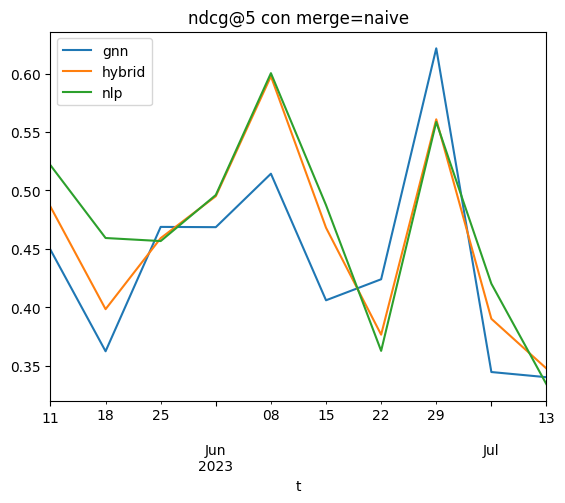

In [22]:
dfm_all.groupby('model')['ndcg@5'].plot(legend=True)
plt.title(f'ndcg@5 con merge={MERGE_FUNC}')

Text(0.5, 1.0, 'ndcg@10 con merge=naive')

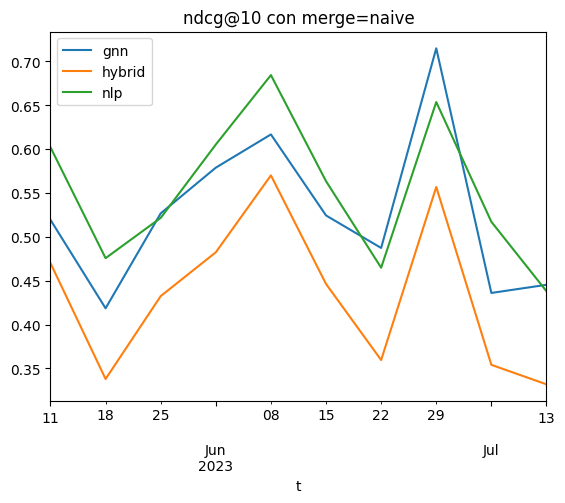

In [23]:
dfm_all.groupby('model')['ndcg@10'].plot(legend=True)
plt.title(f'ndcg@10 con merge={MERGE_FUNC}')

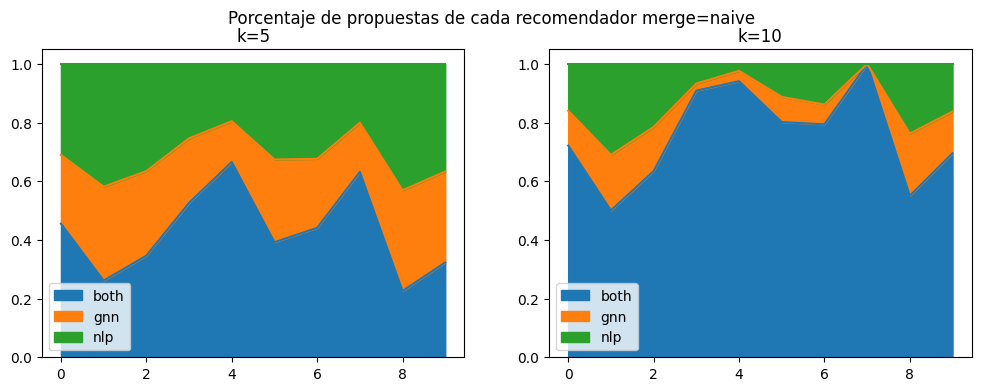

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plt.suptitle(f'Porcentaje de propuestas de cada recomendador merge={MERGE_FUNC}')
for ax, k in zip(axes, [5,10]):
    pct_metrics[k].plot.area(ax=ax)
    ax.set_title(f'k={k}')

Text(0.5, 1.0, 'Porcentaje de elementos comunes entre los dos recsys')

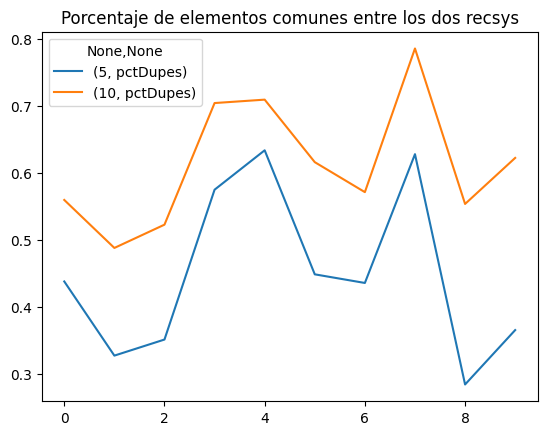

In [25]:
# TODO: Imprimir el porcentaje de propuestas duplicadas/exclusivas
# for k in debug_metrics.columns.get_level_values(0):
#     debug_metrics[k, 'pctExclusive'] = 1 - debug_metrics[k, 'pctDupes']
# debug_metrics = debug_metrics.sort_index(axis=1)

debug_metrics.plot()
plt.title("Porcentaje de elementos comunes entre los dos recsys")

In [26]:
model.nlp.recommend_k_items(
    to_users=test['userID'].unique(),
    top_k=5,
    recommend_from=open_proposals,
)

,userID,itemID,prediction
0,0xe5104e449950180c459447f2971c8a760456b635,90201959-294b-52c2-945d-be3df6f983ea,2.487362
1,0xe5104e449950180c459447f2971c8a760456b635,e5fcfaed-fd89-547f-aba0-b682b2114a4b,2.317582
2,0xe5104e449950180c459447f2971c8a760456b635,ca076ff5-a6b0-5fb8-9edf-e47bd1eb7f08,2.279521
3,0xe5104e449950180c459447f2971c8a760456b635,21676de6-535a-5820-a7bb-b90e0f11b859,2.274050
4,0xe5104e449950180c459447f2971c8a760456b635,55ed051f-19ef-59c0-92e4-9244bb5d04d3,2.258065
...,...,...,...
685,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,0b095940-bbd8-5027-be94-7011312011bc,1.188677
686,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,bfc7adb9-a9cc-5b07-9c22-1b2825ca70b8,0.880780
687,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,21676de6-535a-5820-a7bb-b90e0f11b859,0.873745
688,0xfabe9cb4fa6f0dfbf9088c9ec93304383383475d,390c1db9-bdca-5c44-9b62-c6683c536d11,0.861840
